
<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />

## Workshet 8.1 Deep Learning: Convolutional neural networks

This notebook shows three commonly used neural network architectures to train a model that can classify images of fingerprints.

Data source: JinZhuXing [Fingerprint Dataset for FVC2000_DB4_B in Kaggle](https://www.kaggle.com/peace1019/fingerprint-dataset-for-fvc2000-db4-b)

Useful Notebooks: 

[https://www.kaggle.com/code/peace1019/train-and-eval-20200410](https://www.kaggle.com/code/peace1019/train-and-eval-20200410)

[https://www.kaggle.com/code/sayeefmahmud/fingerprint-detector](https://www.kaggle.com/code/sayeefmahmud/fingerprint-detector)

Libraries for this worksheet:
- [Keras](https://keras.io/) is used as high-level API for [tensorflow](https://www.tensorflow.org/) backend
- PIL
- shutil (built in python library)
- collections
- sci-kit learn
- pydot (graphViz to print out the model layers)
- numpy
- matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing import image
from keras.utils import to_categorical, plot_model
from keras.applications import VGG16
from keras import layers, models,  regularizers, optimizers, callbacks
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.models import Sequential

#import pydot

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
import pickle
from PIL import Image
from collections import defaultdict
import shutil
import os
import datetime

print("Version: ", tf.__version__)


Version:  2.18.1
Eager mode:  True
GPU:  NOT AVAILABLE


In [2]:
import sys
sys.version

'3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 14:46:42) [Clang 14.0.6 ]'

# Load Data

1. Go into the ```../data/fingerprints/``` directory and extract the `.zip` file. This will result in a `train_data` directory that has a bunch of `.bmp` images (our raw data).  

The  .bmp files are named with a 4-digit ID for the person, followed by a two-digit sequence number pertaining to (likely) the finger number, though we don't know for sure so we will just treat it as a sequential ID. 
```
00001_04.bmp
00001_06.bmp
```


In [5]:
DATA_HOME = '../data/fingerprints'

# Path to dataset folder
TRAIN_DATA_RAW_PATH = os.path.join(DATA_HOME, "train_data")

In [6]:
# Dictionary to store the count of fingerprints per person
person_fingerprints = defaultdict(int)

# Iterate over files
for filename in os.listdir(TRAIN_DATA_RAW_PATH):
    if filename.endswith(".bmp"): 
        person_id = filename.split("_")[0]  # Extract the person ID 
        person_fingerprints[person_id] += 1

### Visualize Data

Image: ../data/fingerprints/train_data/00002_38.bmp, Dimensions: (160, 160)


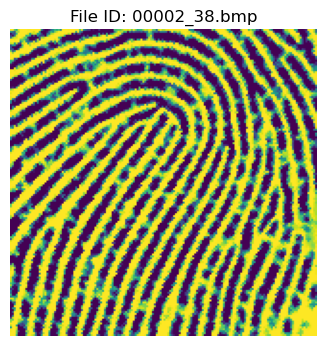

In [7]:
# Randomly sample and plot one of our raw data files
sample_images = []
for file_id in random.sample(os.listdir(TRAIN_DATA_RAW_PATH), 1):  
    img_path =  os.path.join(TRAIN_DATA_RAW_PATH, file_id) 

# Plot the fingerprint
plt.figure(figsize=(10, 10))
img = Image.open(img_path)
plt.subplot(3, 2, 1)
plt.imshow(img) #, cmap="gray")  # change to grayscale image, since that's what it is irl
plt.title(f"File ID: {file_id}")
plt.axis("off")
print(f"Image: {img_path}, Dimensions: {img.size}")  # Print dimensions

plt.tight_layout()
plt.show()

## Load Data part 2
In order to train the model, we will need to separate the raw files into a train/test/validation split. 
- The training data in **TRAIN_DATA_RAW_PATH**, will need to be organized by person in order to stratify our splits. 

In [8]:
# Organize fingerprint files by person
fingerprints_by_person = {}

# Create a dictionary that has each person's ID as the keys and a list of that persons filenames as the value
for filename in os.listdir(TRAIN_DATA_RAW_PATH):
    if filename.endswith(".bmp"):
        person_id = filename.split("_")[0]  # Extract the person ID
        if person_id not in fingerprints_by_person:
            fingerprints_by_person[person_id] = []
        fingerprints_by_person[person_id].append(filename)

In [9]:
# check our dict for one person
fingerprints_by_person['00001'][1:5]

['00001_40.bmp', '00001_68.bmp', '00001_69.bmp', '00001_41.bmp']

### Exercise 1a: Count the number of different people in this dataset, and their fingerprints

In [10]:
# Total number of unique persons
num_persons = len(fingerprints_by_person.keys())

print(f"Total number of persons: {num_persons}")
print("Number of fingerprints per person:")
for person_id, fp_list in fingerprints_by_person.items():
    print(f"Person {person_id}: {len(fp_list)} fingerprints")

Total number of persons: 10
Number of fingerprints per person:
Person 00008: 80 fingerprints
Person 00001: 80 fingerprints
Person 00006: 80 fingerprints
Person 00005: 80 fingerprints
Person 00002: 80 fingerprints
Person 00007: 80 fingerprints
Person 00009: 80 fingerprints
Person 00000: 80 fingerprints
Person 00003: 80 fingerprints
Person 00004: 80 fingerprints


## Train/Test/Validation split
We see that there are usually more than 10 files per person, so it's probably safe to assume that the sequence number does not map to anything.

Next we make the train/test/val split. When doing a multi-class problem like this, we want to make sure we get some data from each class into the train/test and validation datasets. So we need to iterate through each person in the dict and randomly pull out the following ratios:
```
train=70%
validation=15%
test=15%
```

In [11]:
# Output directories 
output_dir = os.path.normpath(os.path.join(DATA_HOME, "split_dataset"))
train_dir = os.path.normpath(os.path.join(output_dir, "train"))
val_dir = os.path.normpath(os.path.join(output_dir, "validation"))
test_dir = os.path.normpath(os.path.join(output_dir, "test"))

# Create directories if they don't exist
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    
# Split data into train/val/test for each person
split_ratios = (0.7, 0.15, 0.15)  # Training, Validation, Test

for person_id, files in fingerprints_by_person.items():
    train_files, temp_files = train_test_split(files, test_size=(1 - split_ratios[0]), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)
    
    # Copy files to the corresponding directories
    for file_list, target_dir in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
        person_dir = os.path.normpath(os.path.join(target_dir, person_id))
        os.makedirs(person_dir, exist_ok=True)
        for file_name in file_list:
            src_path = os.path.normpath(os.path.join(TRAIN_DATA_RAW_PATH, file_name))
            dest_path = os.path.normpath(os.path.join(person_dir, file_name))
            shutil.copy(src_path, dest_path)

print("Dataset successfully split into training, validation, and test sets.")

Dataset successfully split into training, validation, and test sets.


### Visualize Data
Let's look at a few samples for 3 people. 

Image: ../data/fingerprints/split_dataset/train/00006/00006_70.bmp, Dimensions: (160, 160)
Image: ../data/fingerprints/split_dataset/train/00006/00006_22.bmp, Dimensions: (160, 160)
Image: ../data/fingerprints/split_dataset/train/00008/00008_27.bmp, Dimensions: (160, 160)
Image: ../data/fingerprints/split_dataset/train/00008/00008_57.bmp, Dimensions: (160, 160)
Image: ../data/fingerprints/split_dataset/train/00009/00009_77.bmp, Dimensions: (160, 160)
Image: ../data/fingerprints/split_dataset/train/00009/00009_14.bmp, Dimensions: (160, 160)


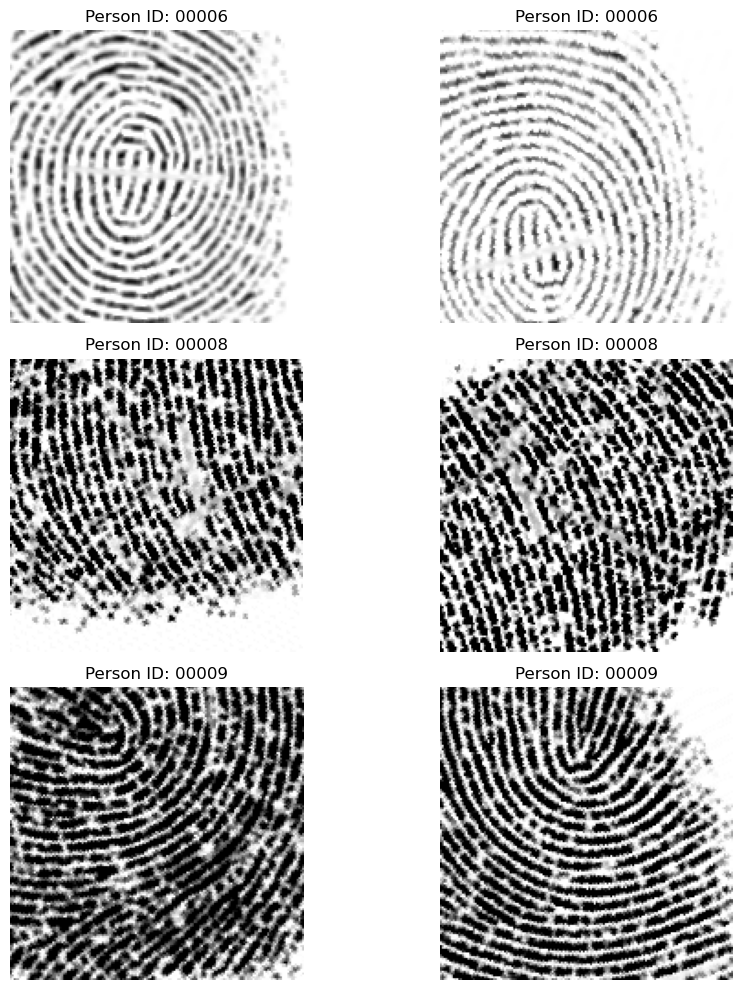

In [12]:
# Randomly sample some person IDs and their fingerprints
sample_images = []
for person_id in random.sample(os.listdir(train_dir), 3):  # Pick 3 random person IDs
    person_path = os.path.join(train_dir, person_id)
    if os.path.isdir(person_path):
        # Pick 2 random images for each person
        sample_images += [(person_id, os.path.join(person_path, img)) 
                          for img in random.sample(os.listdir(person_path), 2)]

# Plot the samples
plt.figure(figsize=(10, 10))
for i, (person_id, img_path) in enumerate(sample_images, 1):
    img = Image.open(img_path)
    plt.subplot(3, 2, i)
    plt.imshow(img, cmap="gray")  # raw data is grayscale images
    plt.title(f"Person ID: {person_id}")
    plt.axis("off")
    print(f"Image: {img_path}, Dimensions: {img.size}")  # Print dimensions

plt.tight_layout()
plt.show()

# Exercise: Train a CNN from scratch to correctly identify the person a fingerprint belongs to
We want to train a model that can classify a fingerprint image as the correct person. This is a multi-class problem (as opposesd to a binary classification problem e.g. Hotdog/not hotdog). Keep in mind that we will need to evaluate this model a bit differently than we do for a binary classification problem. 

## Data Pre-processing
- resize images to be the same *(160, 160)*
- normalize
- convert to grayscale
- save as a numpy array for input into the CNN

In [13]:
def load_and_preprocess_images(image_paths):
    '''
     Load and preprocess grayscale fingerprint images for input into a CNN model. 
     '''
    images = []
    labels = []
    for person_id in os.listdir(image_paths):
        person_path = os.path.join(image_paths, person_id)
        if os.path.isdir(person_path):
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)
                # Load the image
                img = image.load_img(img_path, target_size=(160, 160), color_mode="grayscale")
                # Convert the image to a NumPy array
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(int(person_id))  

    return np.array(images), np.array(labels)

# Load training and validation data
train_images, train_labels = load_and_preprocess_images(train_dir)
train_images = np.array(train_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
train_labels = to_categorical(train_labels)

val_images, val_labels = load_and_preprocess_images(val_dir)
val_images = np.array(val_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
val_labels = to_categorical(val_labels)

test_images, test_labels = load_and_preprocess_images(test_dir)
test_images = np.array(test_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
test_labels = to_categorical(test_labels)

In [14]:
train_images.shape

(550, 160, 160, 1)

In [15]:
train_labels.shape

(550, 10)

## Create a CNN model architecture

In [16]:
final_Dense_units = 10
model_name = 'SubjectIDClassifier'

model_tb = Sequential(name=model_name)

model_tb.add(keras.layers.Input(shape=(160, 160, 1), dtype='float32'))
model_tb.add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_tb.add(layers.BatchNormalization())
model_tb.add(layers.MaxPool2D((2, 2)))
model_tb.add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_tb.add(layers.BatchNormalization())
model_tb.add(layers.MaxPool2D((2, 2)))
model_tb.add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_tb.add(layers.BatchNormalization())
model_tb.add(layers.MaxPool2D((2, 2)))
model_tb.add(layers.Dropout(0.5))
model_tb.add(layers.Flatten())
model_tb.add(layers.Dense(256, activation='relu'))
model_tb.add(layers.Dropout(0.4))
model_tb.add(layers.Dense(final_Dense_units, activation='softmax'))

# Complete with Adam optimizer and entropy cost
model_tb.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
model_tb.summary()

Model: "SubjectIDClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 156, 156, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 156, 156, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 78, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 35, 35, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 35, 35, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,599,626 (36.62 MB)

 Trainable params: 9,599,178 (36.62 MB)

 Non-trainable params: 448 (1.75 KB)

## Set Hyperparameters:
- Set the **epochs**
- Set the **batch_size**

### Callbacks
- Callbacks in Keras are objects that are called at different points during training (at the start of an epoch, at the end of a batch, at the end of an epoch, etc.). They can be used to implement certain behaviors, such as:

- Doing validation at different points during training (beyond the built-in per-epoch validation)
- Checkpointing the model at regular intervals or when it exceeds a certain accuracy threshold
- Changing the learning rate of the model when training seems to be plateauing
- Doing fine-tuning of the top layers when training seems to be plateauing
- Sending email or instant message notifications when training ends or where a certain performance threshold is exceeded
- Etc.

Callbacks can be passed as a list to your call to fit():


In [17]:
epochs = 20
batch_size = 64

CallBack = [
        callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1,
            ),
         callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
            
           
        #callbacks.TensorBoard(log_dir="./log_dir/"+model_name)

## Train (fit) the model 
**Fit** the model to the training data that you just prepared and use the validation data to evaluate the model.
- HINT: see the **validation_data** parameter for the *.fit* method)

In [18]:
history = model_tb.fit(train_images, 
                          train_labels,
                          batch_size = batch_size,
                          epochs = epochs, 
                          validation_data = (val_images, val_labels),
                          verbose = 1, 
                          callbacks= CallBack
                         )


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 548ms/step - accuracy: 0.1535 - loss: 5.4060 - val_accuracy: 0.1000 - val_loss: 2.4387
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.3016 - loss: 2.8998 - val_accuracy: 0.1250 - val_loss: 2.4146
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - accuracy: 0.3724 - loss: 2.0122 - val_accuracy: 0.1917 - val_loss: 2.5020
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - accuracy: 0.4312 - loss: 1.6826 - val_accuracy: 0.1000 - val_loss: 3.1489
Epoch 4: early stopping


## Evaluation
Evaluate the model on the test set. 

1. What is the accuracy of our model on the test set?
2. Is this much lower/higher than what was happening above on the validation set?
3. Train the model again and adjust some of the parameters of the model to try to improve the performance of the model. 

In [19]:
# Evaluate on the test set
test_loss, test_acc = model_tb.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1744 - loss: 2.8628
Test Loss: 3.175600528717041
Test Accuracy: 0.10000000149011612


## Saving your model (optional)
Saving a model is straightforward, it can be done with the *pickle* library, or the *h5* library, or the keras native format. 

In [31]:
model_tb.save("subjectIDClassifier_1.keras")

# Exercise: Fingerprint Authentication
Create an additional function that will take in a raw .bmp image of a fingerprint, predict the ownder's ID, and validate whether the model has correctly predicted the owner. 

In [74]:
def authenticate_fingerprint(one_image, model):
    
    # Load the image
    plt.figure(figsize=(10, 10))
   # img = Image.open( image_path)
    plt.subplot(3, 2, 1)
    plt.imshow(one_image, cmap="gray")  # raw data is grayscale images
    plt.axis("off")
    #print(f"Image: {one_image}, Dimensions: {one_image.size}")  # Print dimensions

    img_final = one_image.reshape(-1, 160, 160, 1).astype('float32') / 255.0

    # Predict the fingerprint features
    predictions = model.predict(img_final)
    print("the fingerprint is predicted as person 0000" + str(np.argmax( predictions)) + ' with  ' + str(np.max(predictions)))
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
the fingerprint is predicted as person 00009 with  0.71748906
ground truth 00009


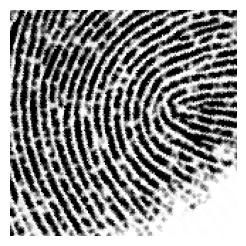

In [78]:
# Register the fingerprint features
sample_num = 2
image_to_verify = test_images[sample_num]
# Authenticate the fingerprint
authenticate_fingerprint(image_to_verify, model_tb)
print('ground truth 0000' + str(test_labels[sample_num]))

# Exercise 2: Using a pre-trained model using Keras
We can utilize a pre-trained image model to make it easier for our model to learn our dataset. VGG is an classic image model that was trained to classify images during the infamous ImageNet Challenge 2014. What we will do is **transfer** this knowledge from the VGG model to our model by **fine-tuning** the last few layers to our data. 

Prepare the images. this time we will not use grayscale b/c this model has been trained on color images and the color could have additional information. 
- load and size the images
- convert to a numpy array
- use RGB (instead of converting to grayscale)
- Normalize

In [23]:
def load_and_preprocess_images_color(image_paths):
    '''
     Load and preprocess grayscale fingerprint images for input into a CNN model. 
     '''
    images = []
    labels = []
    for person_id in os.listdir(image_paths):
        person_path = os.path.join(image_paths, person_id)
        if os.path.isdir(person_path):
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)
                # Load the image
                img = image.load_img(img_path, target_size=(160, 160), color_mode="grayscale")
                # Convert the image to a NumPy array
                img_array = image.img_to_array(img)
                img_array = np.repeat(img_array, 3, axis=-1) / 255.0 
                
                images.append(img_array)
                labels.append(int(person_id))  

    return np.array(images), np.array(labels)

In [24]:
# Load and process image data for input into CNN
train_images, train_labels = load_and_preprocess_images_color(train_dir)
#train_images = np.array(train_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
#train_labels = to_categorical(train_labels)

val_images, val_labels = load_and_preprocess_images_color(val_dir)
#val_images = np.array(val_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
#val_labels = to_categorical(val_labels)

test_images, test_labels = load_and_preprocess_images_color(test_dir)
#test_images = np.array(test_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
#test_labels = to_categorical(test_labels)

In [25]:
train_images.shape

(550, 160, 160, 3)

In [26]:
train_labels.shape

(550,)

## Use a VGG pre-trained model
### Download model weights
- DownLoad VGG16 weights without the top layer

We exclude the fully connected layers by setting **include_top=False** because we want to replace (**fine-tune**) this with our task (data and 10 classes/labels). 


In [27]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 119s 2us/step


### Initialize base model
#### Freezing layers
If we use the default weights when adding our layer, the first iteration will be very inaccurate which will create a large gradient. 
Remember, we are using backpropagation which will send these huge errors back to the lower level (nice pre-trained layers) which will mess it all up. 

To keep these lower-level features preserved, we can freeze the base model layers, until our new layers have become more stable. 

In [28]:
# Freeze the base layers
base_model.trainable = False

In [29]:
# Build the model architecture that will be specific to our data and task
model_pre_trained = models.Sequential([
    base_model, #frozen pre-trained model
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 classes for fingerprint identification of 10 people
])

# Compile the model
model_pre_trained.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

### Overfitting
Reduce the overfitting by implementing **EarlyStopping**

In [30]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Train the model 
- Use the pre-trained base_model weights initialized above and fit it to our training/validation data.

Notice where the model starts this time in terms of accuracy, and how/if it improves w/ each epoch

In [31]:
# Train the model
model_pre_trained.fit(train_images, train_labels, epochs=10, batch_size=32, 
                      validation_data=(val_images, val_labels), 
                      callbacks=[early_stopping])

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 809ms/step - accuracy: 0.0837 - loss: 2.5491 - val_accuracy: 0.1500 - val_loss: 2.2571
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 809ms/step - accuracy: 0.1502 - loss: 2.4020 - val_accuracy: 0.3583 - val_loss: 2.1973
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 843ms/step - accuracy: 0.1458 - loss: 2.3390 - val_accuracy: 0.3750 - val_loss: 2.1525
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 855ms/step - accuracy: 0.2075 - loss: 2.2688 - val_accuracy: 0.4750 - val_loss: 2.1105
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 891ms/step - accuracy: 0.1802 - loss: 2.1590 - val_accuracy: 0.5000 - val_loss: 2.0715
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 881ms/step - accuracy: 0.2366 - loss: 2.1061 - val_accuracy: 0.5000 - val_loss: 2.0322
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 881ms/step - accuracy: 0.2181 - loss: 2.1233 - val_accuracy: 0.5417 - val_loss: 1.9941
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 884ms/step - accuracy: 0.2992 - loss: 2.0398 - val_accu

In [32]:
# Evaluate on the test set
test_loss, test_acc = model_pre_trained.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.6122 - loss: 1.8421
Test Loss: 1.8464395999908447
Test Accuracy: 0.6153846383094788


Fit the model again

In [33]:
# Train the model
model_pre_trained.fit(train_images, train_labels, epochs=30, batch_size=32, 
          validation_data=(val_images, val_labels), 
          callbacks=[early_stopping])

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 891ms/step - accuracy: 0.3836 - loss: 1.9150 - val_accuracy: 0.5333 - val_loss: 1.8563
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 894ms/step - accuracy: 0.3639 - loss: 1.9047 - val_accuracy: 0.5750 - val_loss: 1.8215
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 896ms/step - accuracy: 0.4209 - loss: 1.8441 - val_accuracy: 0.5417 - val_loss: 1.7890
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 899ms/step - accuracy: 0.4361 - loss: 1.7975 - val_accuracy: 0.6250 - val_loss: 1.7567
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 902ms/step - accuracy: 0.4596 - loss: 1.7760 - val_accuracy: 0.6000 - val_loss: 1.7282
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 908ms/step - accuracy: 0.4441 - loss: 1.7593 - val_accuracy: 0.5667 - val_loss: 1.6987
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 910ms/step - accuracy: 0.4799 - loss: 1.7114 - val_accuracy: 0.5667 - val_loss: 1.6720
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 931ms/step - accuracy: 0.4686 - loss: 1.7135 - val_accu

In [34]:
# Evaluate the model on the test set
test_images, test_labels = load_and_preprocess_images(test_dir)  # Load test data

# Evaluate on the test set
test_loss, test_acc = model_pre_trained.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

I0000 00:00:1754308565.389622 1805999 service.cc:148] XLA service 0x600005314100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754308565.389717 1805999 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-08-04 04:56:05.391078: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at conv_ops.cc:61 : INVALID_ARGUMENT: Depth of input must be a multiple of depth of filter: 1 vs 3

Stack trace for op definition: 
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/runpy.py", line 198, in _run_module_as_main
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/runpy.py", line 88, in _run_code
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/kernelapp.py

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
<stack traces unavailable>
Depth of input must be a multiple of depth of filter: 1 vs 3

Stack trace for op definition: 
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/runpy.py", line 198, in _run_module_as_main
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/runpy.py", line 88, in _run_code
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/asyncio/events.py", line 88, in _run
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code
File "var/folders/5h/1pp070l133x8h55ntfbcv4xw0000gp/T/ipykernel_34936/107305927.py", line 5, in <module>
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 432, in evaluate
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/models/sequential.py", line 213, in call
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/models/functional.py", line 584, in call
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/models/functional.py", line 584, in call
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/ops/nn.py", line 901, in conv
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla
File "opt/miniconda3/envs/gtk-bh-8/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference__conv_xla_23121[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[sequential_1/vgg16_1/block1_conv1_1/StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_23339]

Now fit the model again and choose:
- number of **epochs**
- **batch_size**

Notice what is happening to the accuracy and loss for the train and validation sets as the model continues to train. 

## Saving your model (optional)
Saving a model is straightforward, it can be done with the *pickle* library, or the *h5* library. 

In [ ]:
# Save the model 
model.save('fingerprint_model.h5')

## Loading your model 
If you want to load the model you trained, use the code below

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('fingerprint_model.h5')